In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
trainset = MNIST(
    'data',
    train = True,
    download = True,
    transform = Compose([ToTensor(), Normalize(mean=0.5, std=0.5)])
)

(tensor(-1.), tensor(1.))

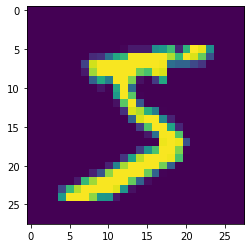

In [ ]:
plt.imshow(trainset[0][0][0])
torch.min(trainset[0][0][0]), torch.max(trainset[0][0][0])

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])


(tensor(0.), tensor(1.))

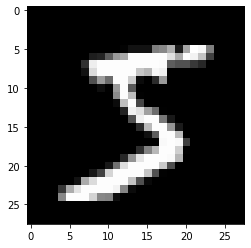

In [ ]:
def denorm(image):
  return (image * 0.5) + 0.5

img_norm = denorm(trainset[0][0])
plt.imshow(img_norm[0], cmap='gray')
print(img_norm[:,10:15,10:15])
torch.min(denorm(trainset[0][0])), torch.max(denorm(trainset[0][0]))

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(images), nrow=10).permute(1, 2, 0))
        print(images.shape)
        print(labels)
        break

In [ ]:
# Declaring some golbal variables

x, y, z = trainset[0][0].shape    # It gives us each dimension size of an image
image_size = x*y*z
batch_size = 100
hidden_size = 256   # hidden layer's shape
latent_size = 64    # latent space size

torch.Size([100, 1, 28, 28])
tensor([1, 6, 9, 7, 6, 2, 9, 5, 9, 0, 5, 7, 4, 5, 1, 5, 1, 2, 6, 7, 9, 9, 9, 8,
        1, 6, 6, 3, 3, 8, 8, 0, 7, 1, 1, 5, 3, 2, 7, 9, 8, 8, 0, 0, 4, 9, 0, 0,
        9, 2, 8, 8, 7, 0, 5, 6, 3, 0, 0, 0, 2, 6, 2, 9, 9, 1, 7, 3, 4, 1, 1, 4,
        5, 3, 4, 2, 8, 6, 9, 4, 2, 4, 7, 5, 5, 0, 3, 5, 9, 0, 0, 0, 5, 1, 1, 3,
        2, 4, 5, 8])


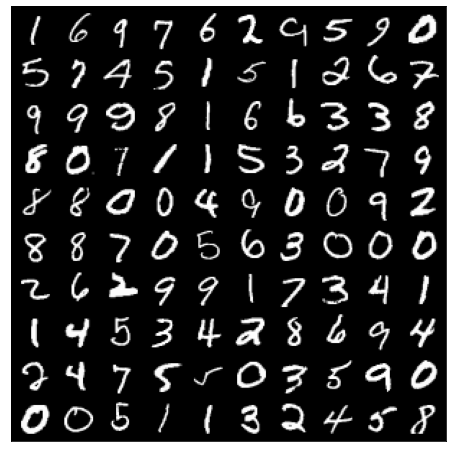

In [ ]:
# Turning the data into bunch of batches i.e DataLoader
data = DataLoader(trainset, batch_size, shuffle=True)

# Visualizing a batch
show_batch(data)

In [ ]:
# Creating the discriminator
Discriminator = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

# Creating the generator
Generator =  nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

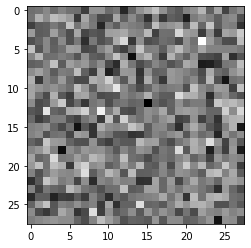

In [ ]:
flat_img = Generator(torch.randn(latent_size))    # a rand array of latent size is given as input
img = denorm(flat_img.reshape((trainset[0][0].shape[1], trainset[0][0].shape[2])).detach())   #turning the flat image vector into a matrix shape
plt.imshow(img, cmap='gray')

In [ ]:
#@title GPU accessing functions
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Discriminator.to(device)
Generator.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [ ]:
# Predefining optimizer, loss types
d_optimizer = torch.optim.Adam(Discriminator.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(Generator.parameters(), lr=0.0002)
criterion = nn.BCELoss()

In [ ]:
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

# Discriminator's training routine
def train_discriminator(real_images):

  # making 0-1 labels to feed in the loss function
  real_labels = torch.ones(batch_size, 1).to(device)
  fake_labels = torch.zeros(batch_size, 1).to(device)

  # feeding real image in discriminator and recording it's loss
  outputs = Discriminator(real_images)
  loss_real = criterion(outputs, real_labels)   # will return high loss if discriminator doesn't predict real imgs as 1
  real_score = outputs

  # feeding fake image in discriminator and recording it's loss
  # got to generate fake image first, to feed in
  latent_variable = torch.randn(batch_size, latent_size).to(device)   # random space for the generator to synthesize fake images from
  fake_images = Generator(latent_variable)
  outputs = Discriminator(fake_images)
  loss_fake = criterion(outputs, fake_labels)    # will return high loss if discriminator doesn't predict fake imgs as 0
  fake_score = outputs

  # aggregate loss for real & fake images, backpropagate the losses so that it does better in future
  loss = loss_real + loss_fake
  reset_grad()    # resetting prev gradients
  loss.backward()
  d_optimizer.step()

  return loss, real_score, fake_score

In [ ]:
# Generator's training routine
def train_generator():
  # creating some fake images first
  latent_variable = torch.randn(batch_size, latent_size).to(device)
  fake_images = Generator(latent_variable)
  labels = torch.ones(batch_size, 1).to(device)   # labeling fake images as 1 i.e. real
  
  # calculating loss for these fake images
  loss = criterion(Discriminator(fake_images), labels)    # high loss if discriminator recognize fake imgs and label them as '0'
  
  reset_grad()    # resetting prev gradients
  
  loss.backward()
  g_optimizer.step()

  return loss, fake_images

Saving fake_images-0000.png


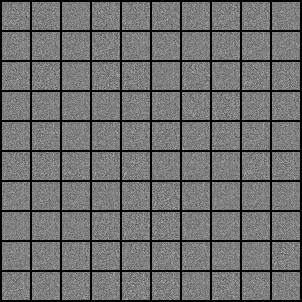

In [ ]:
#@title functions to save real & fake images for visualization 

import os
from IPython.display import Image
from torchvision.utils import save_image

# creating directory to save samples in
sample_dir = 'samples'
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

# function to save a batch of real images
def save_real_images(data):
  for images, _ in data:
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

# create sample latent variables for fake image creation
sample_latent_variables = torch.randn(batch_size, latent_size).to(device)

# function to save a batch of fake images
def save_fake_images(index):
  fake_images = Generator(sample_latent_variables)
  fake_images = fake_images.reshape(batch_size, trainset[0][0].shape[0], trainset[0][0].shape[1], trainset[0][0].shape[2])  # turning the flat img vector produced by generator into proper batch tensor
  img_name = "fake_images-{0:0=4d}.png".format(index)
  print('Saving', img_name)
  save_image(denorm(fake_images), os.path.join(sample_dir, img_name), nrow=10)

# saving a batch of real images
save_real_images(data)
Image(os.path.join(sample_dir, 'real_images.png'))

# fake images before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
%%time

epochs = 500
total_step = len(data)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(epochs):
  for i, (images, _) in enumerate(data):
    # converting the images into long flat vectors to feed into discriminator
    images = images.reshape(batch_size, -1).to(device)

    # training discriminator
    d_loss, real_score, fake_score = train_discriminator(images)
    
    # training generator
    g_loss, fake_images = train_generator()

    # Printing the losses
    if (i+1) % 200 == 0:
      d_losses.append(d_loss.item())
      g_losses.append(g_loss.item())
      real_scores.append(real_score.mean().item())
      fake_scores.append(fake_score.mean().item())
      print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
            .format(epoch, epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                    real_score.mean().item(), fake_score.mean().item()))
  
  # saving a sample of fake images after each epoch of training
  save_fake_images(epoch+1)

Epoch [0/500], Step [200/600], d_loss: 0.0268, g_loss: 4.5601, D(x): 0.99, D(G(z)): 0.02
Epoch [0/500], Step [400/600], d_loss: 0.1562, g_loss: 5.1112, D(x): 0.95, D(G(z)): 0.06
Epoch [0/500], Step [600/600], d_loss: 0.0303, g_loss: 5.2004, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/500], Step [200/600], d_loss: 0.1156, g_loss: 4.2436, D(x): 0.97, D(G(z)): 0.08
Epoch [1/500], Step [400/600], d_loss: 0.0997, g_loss: 3.7278, D(x): 0.97, D(G(z)): 0.06
Epoch [1/500], Step [600/600], d_loss: 0.4698, g_loss: 3.3534, D(x): 0.91, D(G(z)): 0.23
Saving fake_images-0002.png
Epoch [2/500], Step [200/600], d_loss: 0.0882, g_loss: 5.0536, D(x): 0.95, D(G(z)): 0.02
Epoch [2/500], Step [400/600], d_loss: 0.3088, g_loss: 3.1315, D(x): 0.89, D(G(z)): 0.14
Epoch [2/500], Step [600/600], d_loss: 0.1115, g_loss: 4.0603, D(x): 0.95, D(G(z)): 0.05
Saving fake_images-0003.png
Epoch [3/500], Step [200/600], d_loss: 0.4133, g_loss: 2.4775, D(x): 0.86, D(G(z)): 0.15
Epoch [3/500], Step [400/6

In [ ]:
import cv2
import os
from IPython.display import FileLink

video_name = "GANS_training.avi"

# listing all the fake images from "sample_dir" directory
generated_images = [os.path.join(sample_dir, image) for image in os.listdir(sample_dir) if "fake_images" in image]
generated_images.sort()

out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 8, (302, 302))
[out.write(cv2.imread(img)) for img in generated_images]
out.release()
FileLink(video_name)

/content/GANS_training.avi

In [ ]:
# Save the model checkpoints 
torch.save(Generator.state_dict(), 'G.ckpt')
torch.save(Discriminator.state_dict(), 'D.ckpt')

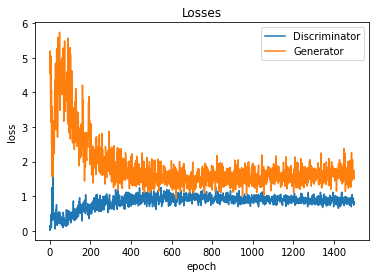

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

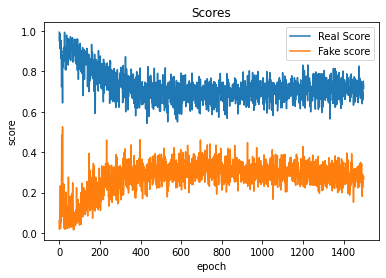

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');